In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import glob
import h5py
import re

In [2]:
directory = '//allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_plots/figure_4/all_cre_clustering_090923_select_k/'

# Regular expression to match the desired file names
pattern = r'cluster_meta_n_(\d+)_clusters\.h5'

# Function to extract the number from the file name
def extract_number(filename):
    match = re.search(pattern, filename)
    if match:
        return int(match.group(1))
    return -1

# Get a list of all files in the directory
all_files = os.listdir(directory)

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


In [4]:
filename = 'cluster_meta_n_14_clusters.h5'

In [7]:
file_path = os.path.join(directory, filename)
cluster_df = pd.read_hdf(file_path, key='df')

#### load cell table to find area and depth

In [8]:
import visual_behavior.data_access.loading as loading
cell_table = loading.get_cell_table()

In [9]:
cell_specimen_ids = cluster_df.cell_specimen_id.values

In [10]:
cell_table2 = cell_table[cell_table.cell_specimen_id.isin(cell_specimen_ids)]

In [78]:
cell_table2.keys()

Index(['cell_specimen_id', 'ophys_experiment_id', 'equipment_name',
       'full_genotype', 'mouse_id', 'reporter_line', 'driver_line', 'sex',
       'age_in_days', 'cre_line', 'indicator', 'session_number',
       'prior_exposures_to_session_type', 'prior_exposures_to_image_set',
       'prior_exposures_to_omissions', 'ophys_session_id',
       'behavior_session_id', 'ophys_container_id', 'project_code',
       'imaging_depth', 'targeted_structure', 'date_of_acquisition',
       'session_type', 'experience_level', 'passive', 'image_set', 'file_id',
       'cell_type', 'depth', 'binned_depth', 'area_depth', 'area_binned_depth',
       'layer', 'area_layer', 'date', 'first_novel',
       'n_relative_to_first_novel', 'last_familiar', 'last_familiar_active',
       'second_novel', 'second_novel_active', 'experience_exposure'],
      dtype='object')

In [79]:
cell_table3 = cell_table2[['cell_specimen_id','cell_type', 'depth', 'binned_depth', 'area_depth', 'area_binned_depth',
       'layer', 'area_layer', 'targeted_structure']]
cell_table4 = cell_table3.drop_duplicates('cell_specimen_id')

In [80]:
cluster_df_all = pd.merge(cluster_df, cell_table4, on='cell_specimen_id', how='inner')

In [13]:
cluster_df_all['location'] = cluster_df_all['area_layer'].copy()

#### use GLM clustering code to generate the area/depth analysis

In [14]:
import visual_behavior_glm.GLM_clustering as glm_clust

In [15]:
cluster_df_all.location.unique()

array(['VISp_upper', 'VISp_lower', 'VISl_upper', 'VISl_lower'],
      dtype=object)

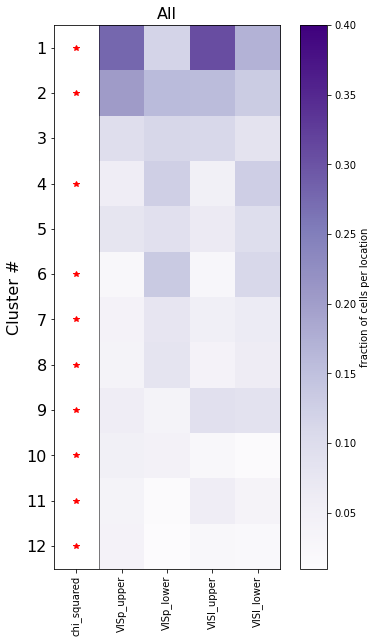

In [16]:
areas = ['VISp_upper', 'VISp_lower', 'VISl_upper', 'VISl_lower']
cre = 'none'
fig, ax = plt.subplots(1,1, figsize = (7,10))
glm_clust.plot_proportion_cre(df=cluster_df_all, areas=areas, fig=fig, ax=ax, cre=cre,test='chi_squared_')

#### Use cre lines

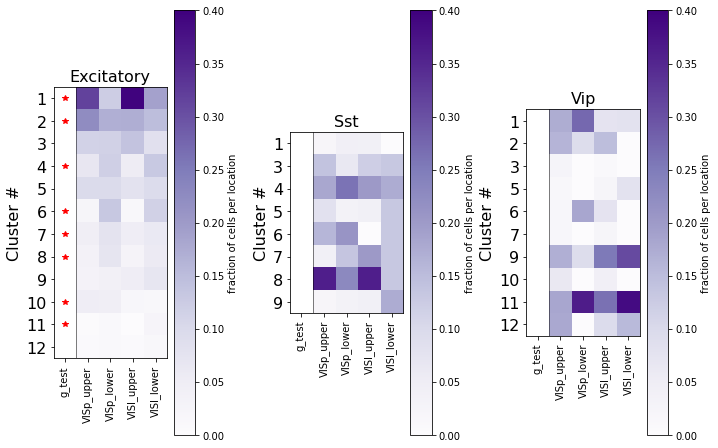

In [22]:
areas = ['VISp_upper', 'VISp_lower', 'VISl_upper', 'VISl_lower']

fig, ax = plt.subplots(1,3, figsize = (10,7))
for i,cre in enumerate(np.sort(cluster_df_all.cre_line.unique())):
    glm_clust.plot_proportion_cre(df=cluster_df_all, areas=areas, fig=fig, ax=ax[i], cre=cre,test='g_test_')

plt.tight_layout()

Primary visual cortex:
- Overrepresentation of cluster 10 that is modulated by task during novelty. This is super interesting cause you would expect higher visual areas to integrate task related behaviors. This may be related to stronger modulation by movement or licking in the novel session. 

- When using g test, we do not see significant difference in areas for beahvioral cluster 9, which often pops up more LM based.

- non responsive cells are likely to be in superficial layers.

- Novelty cells are prominent in superficial V1.

- Deep layers are more consistently responding to all images, including familiar only. 

- Suppression by novelty excitatory cells are more common in deep layers, while SST are in superficial layers.

#### Bar plot of area and depth representation

In [26]:
cre = 'Slc17a7-IRES2-Cre'
table = glm_clust.compute_proportion_cre(df=cluster_df_all, cre=cre, areas=areas)
table = table.reset_index()

In [36]:

table_VISp = table[['cluster_id', 'VISp_upper', 'VISp_lower']]
table_VISl = table[['cluster_id', 'VISl_upper', 'VISl_lower']]
df_visp = pd.melt(table_VISp, id_vars=['cluster_id'], var_name='location', value_name='proportion')
df_visl = pd.melt(table_VISl, id_vars=['cluster_id'], var_name='location', value_name='proportion')


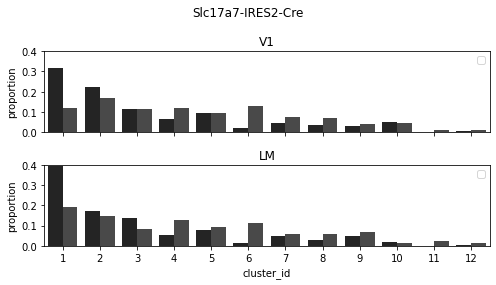

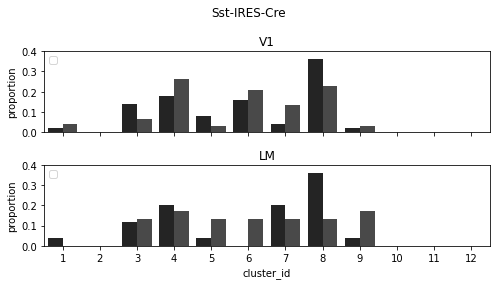

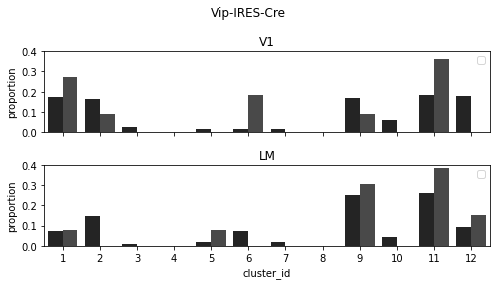

In [75]:

grey_palette = sns.color_palette("gray")
legend=True
for i,cre in enumerate(np.sort(cluster_df_all.cre_line.unique())):
   
    fig, ax = plt.subplots(2,1, figsize = (7,4), sharex=True)
    table = glm_clust.compute_proportion_cre(df=cluster_df_all, cre=cre, areas=areas)
    cluster_range = range(0, 12)
    table = table.reindex(cluster_range).reset_index()
    table['cluster_id'] = table['cluster_id'].copy()+1
    table_VISp = table[['cluster_id', 'VISp_upper', 'VISp_lower']]
    table_VISl = table[['cluster_id', 'VISl_upper', 'VISl_lower']]
    df_visp = pd.melt(table_VISp, id_vars=['cluster_id'], var_name='location', value_name='proportion')
    df_visl = pd.melt(table_VISl, id_vars=['cluster_id'], var_name='location', value_name='proportion')

    sns.barplot(data=df_visp, x='cluster_id', y='proportion', hue='location', palette=grey_palette, ax=ax[0])
    sns.barplot(data=df_visl, x='cluster_id', y='proportion', hue='location', palette=grey_palette, ax=ax[1])
    # if legend is True:
    #     legend=False
    # else:
    #     ax[1].legend('')
    
    # stats
    test='g_test_'
    table2 = glm_clust.stats(df=cluster_df_all, cre=cre, areas=areas, test=test)
    
    ax[0].set_ylim([0, 0.4])
    ax[0].set_title('V1')
    ax[0].legend('')
    ax[0].set_xlabel('')
    ax[1].set_ylim([0, 0.4])
    ax[1].set_title('LM')
    ax[1].legend('')
    plt.suptitle(cre)
    plt.tight_layout()


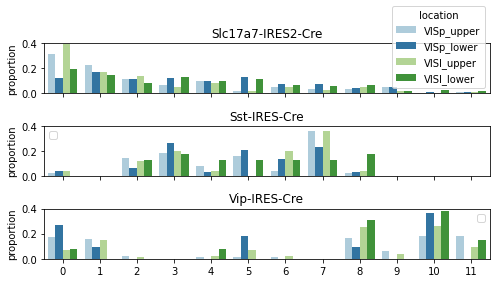

In [73]:

### plot on one bar plot

grey_palette = sns.color_palette("gray")
legend=True
fig, ax = plt.subplots(3,1, figsize = (7,4), sharex=True)

for i,cre in enumerate(np.sort(cluster_df_all.cre_line.unique())):
   
    table = glm_clust.compute_proportion_cre(df=cluster_df_all, cre=cre, areas=areas)
    cluster_range = range(0, 12)
    table = table.reindex(cluster_range).reset_index()
    
    table_long = pd.melt(table, id_vars=['cluster_id'], var_name='location', value_name='proportion')

    sns.barplot(data=table_long, x='cluster_id', y='proportion', hue='location', palette='Paired', ax=ax[i])
    # if legend is True:
    #     legend=False
    # else:
    #     ax[1].legend('')
    
    # stats
    test='g_test_'
    table2 = glm_clust.stats(df=cluster_df_all, cre=cre, areas=areas, test=test)
    
    ax[i].set_ylim([0, 0.4])
    ax[i].set_title(cre)
    if i > 0:
        ax[i].legend('')
    ax[i].set_xlabel('')
   
    plt.tight_layout()


In [71]:
table = glm_clust.compute_proportion_cre(df=cluster_df_all, cre=cre, areas=areas)


In [138]:
locations = {'targeted_structure': ['VISp', 'VISl'],
            'layer': ['upper', 'lower'],
            'area_layer':['VISp_upper', 'VISp_lower', 'VISl_upper', 'VISl_lower']}


In [106]:
# table_cre = table_cre[['cluster_id', 'cre_line', *locations[location]]]

['cluster_id', 'VISp_upper', 'VISp_lower', 'VISl_upper', 'VISl_lower']

### By different location per cluster

#### area

In [188]:
#get cluster df for specific location
location = 'targeted_structure'
cluster_df_all['location'] = cluster_df_all[location].copy()
table_cre = pd.DataFrame()
cluster_range = range(0, 12)
for i,cre in enumerate(np.sort(cluster_df_all.cre_line.unique())):
    areas = locations[location]
    
    # compute the table of proportions
    table = glm_clust.compute_proportion_cre(df=cluster_df_all, cre=cre, areas=areas)
    
    # make sure that there are 12 clusters for all
    table = table.reindex(cluster_range).reset_index()
   
    # add cre line
    table['cre_line'] = cre
    if i == 0:
        table_cre=table.copy()
    else:
        # concatinate tables with all cre
        table_cre = pd.concat([table_cre, table], ignore_index=True)

# start with 1
table_cre['cluster_id'] = table_cre['cluster_id'].copy()+1

# convert to long format
table_long = pd.melt(table_cre, id_vars=['cluster_id', 'cre_line'], var_name='location', value_name='proportion')



In [198]:
for i,cre in enumerate(np.sort(cluster_df_all.cre_line.unique())):
    table2 = glm_clust.stats(df=cluster_df_all, cre=cre, areas=areas, test=test)
    table2 = table2.reindex(cluster_range).reset_index()
    table2['cre_line'] = cre
    if i == 0:
        table2_cre=table2.copy()
    else:
        # concatinate tables with all cre
        table2_cre = pd.concat([table2_cre, table2], ignore_index=True)
table2_cre['cluster_id'] = table2_cre['cluster_id'].copy()+1


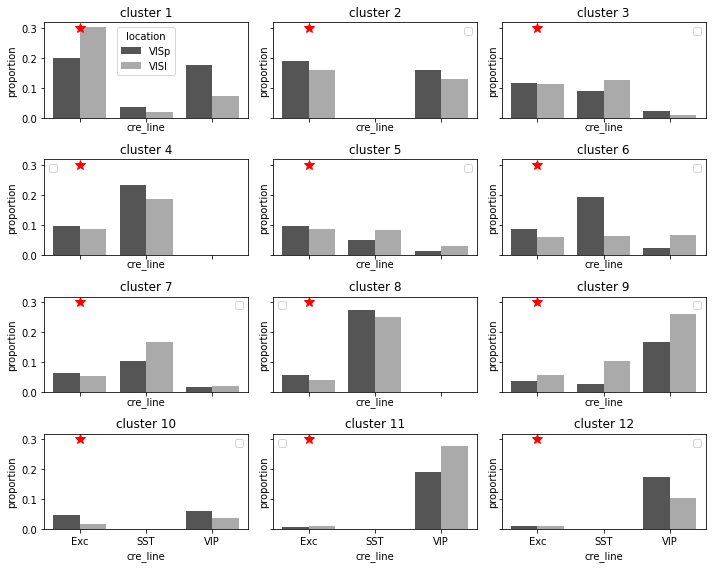

In [210]:
grey_palette = sns.color_palette("gray")
legend=True
fig, axes = plt.subplots(4,3, figsize = (10,8), sharex=True, sharey=True)
axes = axes.ravel()
for j, ax in enumerate(axes):
    sns.barplot(data=table_long[table_long['cluster_id']==j+1], 
                    x='cre_line', y ='proportion', hue = 'location', palette='gray', ax=ax)
    ax.set_xticklabels(['Exc', 'SST', 'VIP'])
    ax.set_title(f'cluster {j+1}')
    if j > 0:
        ax.legend('')
    # plot stats
    table2_cluster = table2_cre[table2_cre['cluster_id']==1][['cre_line', 'bh_significant']].reset_index(drop=True)
    for index in table2_cluster.index.values:
        if table2_cluster.loc[index]['bh_significant']:
            ax.plot(index, 0.3,'r*', markersize = 10)
plt.tight_layout()  

#### layer

In [211]:
#get cluster df for specific location
location = 'layer'
cluster_df_all['location'] = cluster_df_all[location].copy()
table_cre = pd.DataFrame()
cluster_range = range(0, 12)
for i,cre in enumerate(np.sort(cluster_df_all.cre_line.unique())):
    areas = locations[location]
    
    # compute the table of proportions
    table = glm_clust.compute_proportion_cre(df=cluster_df_all, cre=cre, areas=areas)
    
    # make sure that there are 12 clusters for all
    table = table.reindex(cluster_range).reset_index()
   
    # add cre line
    table['cre_line'] = cre
    if i == 0:
        table_cre=table.copy()
    else:
        # concatinate tables with all cre
        table_cre = pd.concat([table_cre, table], ignore_index=True)

# start with 1
table_cre['cluster_id'] = table_cre['cluster_id'].copy()+1

# convert to long format
table_long = pd.melt(table_cre, id_vars=['cluster_id', 'cre_line'], var_name='location', value_name='proportion')



In [212]:
for i,cre in enumerate(np.sort(cluster_df_all.cre_line.unique())):
    areas = locations[location]
    table2 = glm_clust.stats(df=cluster_df_all, cre=cre, areas=areas, test=test)
    table2 = table2.reindex(cluster_range).reset_index()
    table2['cre_line'] = cre
    if i == 0:
        table2_cre=table2.copy()
    else:
        # concatinate tables with all cre
        table2_cre = pd.concat([table2_cre, table2], ignore_index=True)
table2_cre['cluster_id'] = table2_cre['cluster_id'].copy()+1


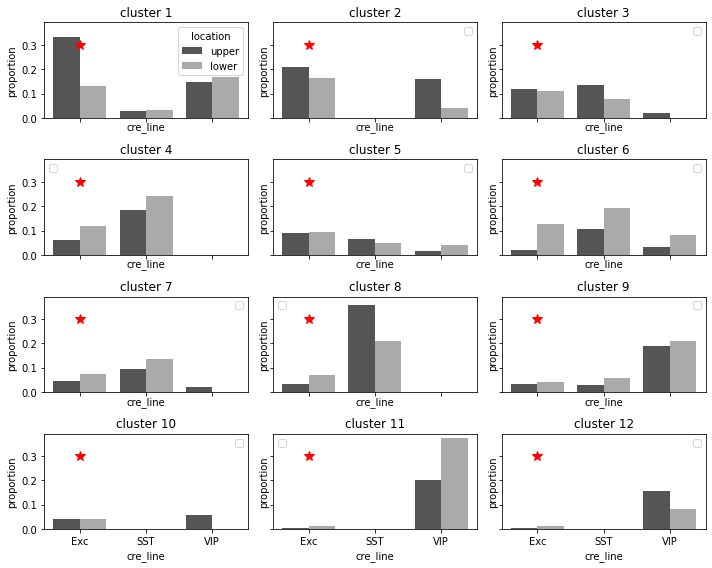

In [213]:
grey_palette = sns.color_palette("gray")
legend=True
fig, axes = plt.subplots(4,3, figsize = (10,8), sharex=True, sharey=True)
axes = axes.ravel()
for j, ax in enumerate(axes):
    sns.barplot(data=table_long[table_long['cluster_id']==j+1], 
                    x='cre_line', y ='proportion', hue = 'location', palette='gray', ax=ax)
    ax.set_xticklabels(['Exc', 'SST', 'VIP'])
    ax.set_title(f'cluster {j+1}')
    if j > 0:
        ax.legend('')
     # plot stats
    table2_cluster = table2_cre[table2_cre['cluster_id']==1][['cre_line', 'bh_significant']].reset_index(drop=True)
    for index in table2_cluster.index.values:
        if table2_cluster.loc[index]['bh_significant']:
            ax.plot(index, 0.3,'r*', markersize = 10)
plt.tight_layout()  

#### area and depth

In [214]:
#get cluster df for specific location
location = 'area_layer'
cluster_df_all['location'] = cluster_df_all[location].copy()
table_cre = pd.DataFrame()
cluster_range = range(0, 12)
for i,cre in enumerate(np.sort(cluster_df_all.cre_line.unique())):
    areas = locations[location]
    
    # compute the table of proportions
    table = glm_clust.compute_proportion_cre(df=cluster_df_all, cre=cre, areas=areas)
    
    # make sure that there are 12 clusters for all
    table = table.reindex(cluster_range).reset_index()
   
    # add cre line
    table['cre_line'] = cre
    if i == 0:
        table_cre=table.copy()
    else:
        # concatinate tables with all cre
        table_cre = pd.concat([table_cre, table], ignore_index=True)

# start with 1
table_cre['cluster_id'] = table_cre['cluster_id'].copy()+1

# convert to long format
table_long = pd.melt(table_cre, id_vars=['cluster_id', 'cre_line'], var_name='location', value_name='proportion')


In [215]:
for i,cre in enumerate(np.sort(cluster_df_all.cre_line.unique())):
    table2 = glm_clust.stats(df=cluster_df_all, cre=cre, areas=areas, test=test)
    table2 = table2.reindex(cluster_range).reset_index()
    table2['cre_line'] = cre
    if i == 0:
        table2_cre=table2.copy()
    else:
        # concatinate tables with all cre
        table2_cre = pd.concat([table2_cre, table2], ignore_index=True)
table2_cre['cluster_id'] = table2_cre['cluster_id'].copy()+1

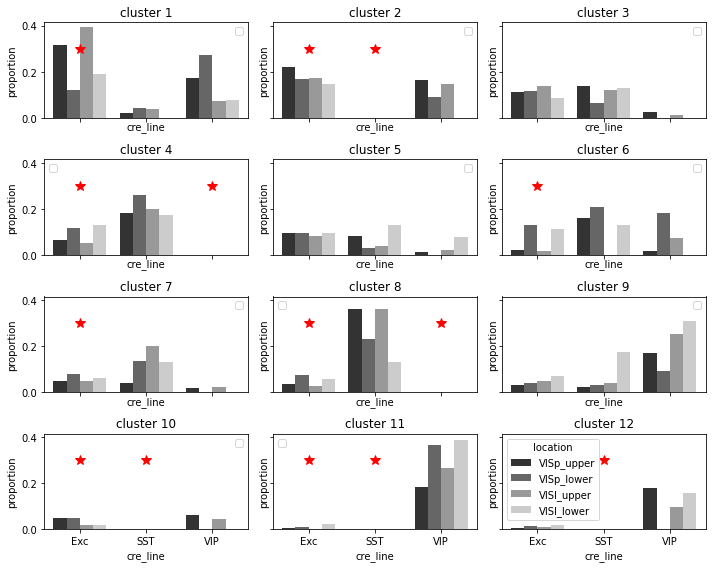

In [221]:
grey_palette = sns.color_palette("gray")
legend=True
fig, axes = plt.subplots(4,3, figsize = (10,8), sharex=True, sharey=True)
axes = axes.ravel()
for j, ax in enumerate(axes):
    sns.barplot(data=table_long[table_long['cluster_id']==j+1], 
                    x='cre_line', y ='proportion', hue = 'location', palette='gray', ax=ax)
    ax.set_xticklabels(['Exc', 'SST', 'VIP'])
    ax.set_title(f'cluster {j+1}')
     # plot stats
    table2_cluster = table2_cre[table2_cre['cluster_id']==j+1][['cre_line', 'bh_significant']].reset_index(drop=True)
    for index in table2_cluster.index.values:
        if table2_cluster.loc[index]['bh_significant']:
            ax.plot(index, 0.3,'r*', markersize = 10)
    if j != 11:
        ax.legend('')
plt.tight_layout()  

In [219]:
table2_cluster.index.values

array([0, 1, 2], dtype=int64)